# Use Public Resources

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jburel/EOSC-14176/blob/main/notebooks/pidar_idr.ipynb)

## Learning Objectives

* How to access data stored in [Preclinical image dataset repository](https://pidar.hpc4ai.unito.it/)(PIDAR)
* How to access data stored in [Image Data Resource](https://idr.openmicroscopy.org/) (IDR)
* How to do cross resources investigation

### Import libraries 
Import libraries to interact with the resources

In [1]:
import requests
import json

## First retrieve information about datasets stored in PIDAR
We load and parse the ``json`` file.

In [2]:
UNITO_URL_JSON = "https://pidar.hpc4ai.unito.it/file.json"
import urllib.request, json 
with urllib.request.urlopen(UNITO_URL_JSON) as url:
    data = json.load(url)

## Search for datasets
We explore studies associated to:
* a disease model
* a species
* an organ or tissue

In [3]:
# Key can be modified according to the investigation
KEYS = ["disease model", "species", "organ or tissue"]

In [4]:
# Helper method to search into the content of PIDAR
def find_pidar(model, species, organ):
    results = []
    for d in data:
        values = []   
        for key, value in d.items():
            k = key.lower().strip()
            if k in KEYS:
                values.append(value.lower().strip())
        if any(model in s for s in values) and any(species in s for s in values) and any(organ in s for s in values):
            results.append(d)
    return results

# Case study #1

## Search for healthy animals in PIDAR

In [5]:
results = find_pidar("naive", "mice", "liver")

## Check the compound
For this investigation, we are interested to explore the compound used and see if it was used for investigation in recent studies in IDR.

Using the output results from the search in PIDAR, we use the ``CHEBI:ID`` used in PIDAR to annotate the sample data and explore IDR. 

In [6]:
# Retrieve information about the compound
import xml.etree.ElementTree as ET
in_chi_keys = []
for r in results:
    chebi_ulr = "https://www.ebi.ac.uk/chebi/saveStructure.do?xml=true&chebiId=%s&imageId=0" % r["CHEBI pharmaco"]
    with urllib.request.urlopen(chebi_ulr) as url:
        response = url.read()
        tree = ET.fromstring(response)
        in_chi_keys.append(tree.find("ENTRY"))

### Set up to query IDR

In [7]:
INDEX_PAGE = "https://idr.openmicroscopy.org/webclient/?experimenter=-1"

# create http session
with requests.Session() as session:
    request = requests.Request('GET', INDEX_PAGE)
    prepped = session.prepare_request(request)
    response = session.send(prepped)
    if response.status_code != 200:
        response.raise_for_status()

### Search IDR
Search the studies related to the list of compounds found in PIDAR.

In [8]:
SEARCH_URL = "https://idr.openmicroscopy.org/searchengine/api/v1/resources/{type}/search/"
KEY_VALUE_SEARCH = SEARCH_URL + "?key={key}&value={value}"
KEY = "InChIKey"

In [9]:
%%time
import collections
from collections import defaultdict

ickeys = {}
for k in in_chi_keys:
    value = k.find('INCHIKEY').text
    qs1 = {'type': 'image', 'key': KEY, 'value': value}
    url = KEY_VALUE_SEARCH.format(**qs1)
    json = session.get(url).json()
    ickeys[k.find('NAME').text] = json['results']['results']

CPU times: user 76.1 ms, sys: 5.29 ms, total: 81.4 ms
Wall time: 384 ms


## Display the images
Display the images associated associated to the associated compounds.
Click on the thumbnail to open the image in IDR. 

In [10]:
# URLs to retrieve the thumbnails and link to the images in IDR
BASE_URL = "https://idr.openmicroscopy.org/webclient"
IMAGE_DATA_URL = BASE_URL + "/render_thumbnail/{id}"
LINK_URL = BASE_URL + "/?show=image-{id}"

In [11]:
# Display the images
from ipywidgets import AppLayout, widgets

table_widget = widgets.HTML("")

html = ''
for drug, images in ickeys.items():
    html = '<h2>Compound: ' + drug + '</h2>'
    if len(images) > 0:
        html += '<table><tr>'
        for image in images:
            qs = {'id': image['id']}
            url = IMAGE_DATA_URL.format(**qs)
            url_link = LINK_URL.format(**qs)
            html += '<td><a href="'+url_link+'" target="_blank"><img src="'+url+'"/></a>&nbsp;&nbsp;</td>'
        html += '<tr>'
        html += "</table>"

table_widget.value = html
AppLayout(header=None,
          left_sidebar=None,
          center=table_widget,
          right_sidebar=None,
          footer=None)

AppLayout(children=(HTML(value='<h2>Compound: plerixafor</h2><table><tr><td><a href="https://idr.openmicroscop…

# Case Study #2

### Cross Species investigation: First search PIDAR

In [12]:
results = find_pidar("neuro", "mice", "brain")

In [13]:
for r in results:
    v = r["Study description"]
    print(v)

VCAM-1 paramagnetic micelles to detect neuroinflammation by MRI


## Search Gene
The gene ``VCAM1`` is returned.
We are now looking in [Image Data Resource](https://idr.openmicroscopy.org/) for studies linked to those genes
Documentation about the search API used by IDR is available at [omero-search-engine](https://omero-search-engine.readthedocs.io/en/latest/).

In [14]:
%%time
import collections
from collections import defaultdict

gene = 'VCAM1'
qs1 = {'type': 'image', 'key': 'Gene Symbol', 'value': gene}
url = KEY_VALUE_SEARCH.format(**qs1)
json = session.get(url).json()
images = json['results']['results']

CPU times: user 46.4 ms, sys: 26.6 ms, total: 73.1 ms
Wall time: 976 ms


## Find the image with the following key(s) and value

In [15]:
PART_KEY = "Organism Part"
PATHOLOGY_KEY = "Pathology"
PATHOLOGY_NORMAL_VALUE = "Normal"

In [16]:
pathology_images = {}
result_images = defaultdict(list)
PARTS = ['Cerebral cortex', 'Hippocampus', 'Cerebellum', 'Brain']
for image in images:
    values = image["key_values"]
    part = None
    for v in values:
        name = v["name"]
        value = v['value']
        if name is not None and PART_KEY == name and value in PARTS:
            part = value
    for v in values:
        name = v["name"]
        value = v['value']
        if part is not None and name == PATHOLOGY_KEY:
            if PATHOLOGY_NORMAL_VALUE in value:
                result_images[PATHOLOGY_NORMAL_VALUE].append(image["id"])
            else:
                result_images[value].append(image["id"])

## Filter images with a given Organism Part value

We explore the images associated to the gene **PDX1** with abnormal pathology status.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<Axes: ylabel='disease'>

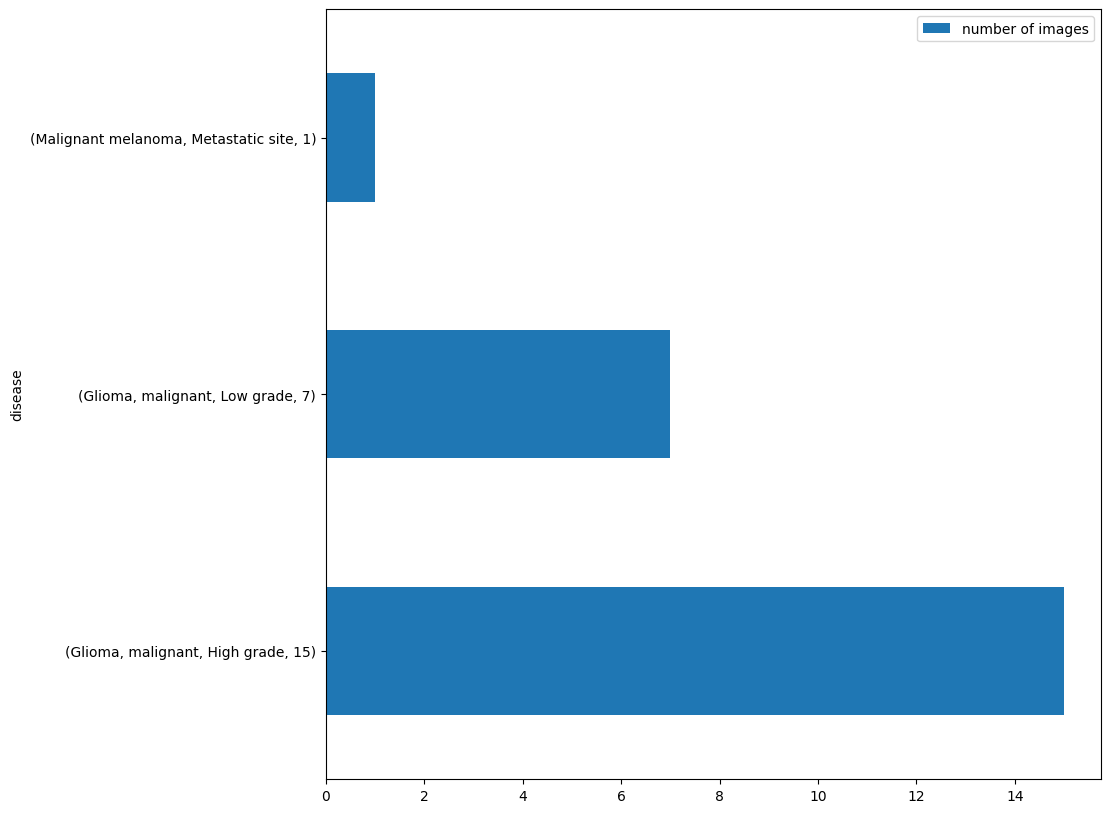

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
disease_map = {}
for k, v in result_images.items():
        if k != PATHOLOGY_NORMAL_VALUE:
            disease_map[k] = len(v)

disease_ordered = collections.OrderedDict(sorted(disease_map.items()))
df = pd.DataFrame({'disease':disease_ordered.items(),
                    'number of images':disease_ordered.values()})
df.plot(kind='barh', x='disease', y='number of images', figsize=(10,10))

## Select the disease and display the associated images
Click on the thumbnail to open the image in IDR.

In [18]:
from ipywidgets import GridspecLayout, widgets

increase = 8
max_value = increase
min_value = 0

disease = ""

def display_images(images, min, max):
    html = "<table>"
    html += '<tr>'
    if min < 0:
        min = 0
    if max >= len(images):
        max = len(images)

    
    for i in images[min:max]:
        qs = {'id': i}
        url = IMAGE_DATA_URL.format(**qs)
        url_link = LINK_URL.format(**qs)
        html += '<td><a href="'+url_link+'" target="_blank"><img src="'+url+'"/></a>&nbsp;</td>'
    html += "</tr>"
    html += "</table>"
    html_widget.value = html
    
    # Set the number of images found
    count_widget.value = "<b>Number of images found: " + str(len(images)) + "</b>"
    
def on_selection_change(change):
    global disease
    if change['name'] == 'value':
        values = get_images(change['new']) 
        if values is None:
            return
        disease = change['new']
        min_value = 0
        max_value = increase 
        display_images(values, min_value, max_value)
                
def get_images(disease):
    for k, v in result_images.items():
        if k == disease:
            return v
    return None
    
def on_click_next(b):
    global min_value
    global max_value
    max_value = max_value + increase
    min_value = min_value + increase
    values = get_images(disease)
    button_previous.disabled = False
    if values is None:
        return
    if max_value > len(values):
        button_next.disabled = True
        
    display_images(values, min_value, max_value)

def on_click_previous(b):
    global min_value
    global max_value
    max_value = max_value - increase
    min_value = min_value - increase
    button_next.disabled = False
    if min_value <= 0:  # reset 
        min_value = 0
        max_value = increase
        button_previous.disabled = True
    values = get_images(disease)
    if values is not None:
        display_images(values, min_value, max_value)
            
def dropdown_widget(disease_list,
                    dropdown_widget_name,
                    displaywidget=False):

    selection = widgets.Dropdown(
        options=disease_list,
        value=disease_list[0],
        description=dropdown_widget_name,
        disabled=False,
    )
    selection.observe(on_selection_change)
    display_images(get_images(selection.value), min_value, max_value)
    return selection

disease_list = list(disease_ordered.keys())
disease = disease_list[0]
gene_widget = widgets.HTML("")
count_widget = widgets.HTML("")
html_widget = widgets.HTML("")
disease_box = dropdown_widget(
    disease_list,
    'Disease: ', True
)

button_next = widgets.Button(description="Next>>")
button_next.on_click(on_click_next)

button_previous = widgets.Button(description="<<Previous", disabled=True)
button_previous.on_click(on_click_previous)

gene_widget.value = "Gene: <b>" + gene + "</b>"

grid = GridspecLayout(3, 3)
grid[0, 0] = gene_widget
grid[0, 1] = disease_box
grid[0, 2] = count_widget
grid[2, 0] = button_previous
grid[1, :] = html_widget
grid[2, 2] = button_next
grid


GridspecLayout(children=(HTML(value='Gene: <b>VCAM1</b>', layout=Layout(grid_area='widget001')), Dropdown(desc…

### License (BSD 2-Clause)¶

Copyright (C) 2023 University of Dundee. All Rights Reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE. 